## Import Libraries and Data

In [2]:
!pip install rouge

In [3]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 136 kB 69.2 MB/s 
     |████████████████████████████████| 1.1 MB 69.6 MB/s 
     |████████████████████████████████| 212 kB 86.2 MB/s 
     |████████████████████████████████| 127 kB 82.5 MB/s 
     |████████████████████████████████| 144 kB 90.0 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 94.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import re
import random
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.layers import Input, LSTM, Embedding, Dense, concatenate, TimeDistributed, Add, dot, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from rouge import Rouge

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [5]:
from datasets import load_dataset
raw_datasets = load_dataset("xsum")

Using custom data configuration default


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [7]:
df_train = pd.DataFrame(data=raw_datasets['train'], columns=raw_datasets['train'].column_names)
df_train.head()

,document,summary,id
0,"The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by stand...",Clean-up operations are continuing across the Scottish Borders and Dumfries and Galloway after flooding caused by Storm Frank.,35232142
1,"A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.\nAs they gathered outside they saw the two buses, parked side-by-si...",Two tourist buses have been destroyed by fire in a suspected arson attack in Belfast city centre.,40143035
2,"Ferrari appeared in a position to challenge until the final laps, when the Mercedes stretched their legs to go half a second clear of the red cars.\nSebastian Vettel will start third ahead of team...",Lewis Hamilton stormed to pole position at the Bahrain Grand Prix ahead of Mercedes team-mate Nico Rosberg.,35951548
3,"John Edward Bates, formerly of Spalding, Lincolnshire, but now living in London, faces a total of 22 charges, including two counts of indecency with a child.\nThe 67-year-old is accused of committ...","A former Lincolnshire Police officer carried out a series of sex attacks on boys, a jury at Lincoln Crown Court was told.",36266422
4,Patients and staff were evacuated from Cerahpasa hospital on Wednesday after a man receiving treatment at the clinic threatened to shoot himself and others.\nOfficers were deployed to negotiate wi...,"An armed man who locked himself into a room at a psychiatric hospital in Istanbul has ended his threat to kill himself, Turkish media report.",38826984


In [8]:
df_train.shape

(204045, 3)

In [9]:
df_test = pd.DataFrame(data=raw_datasets['test'], columns=raw_datasets['test'].column_names)
df_test.head()

,document,summary,id
0,"Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in ho...","There is a ""chronic"" need for more housing for prison leavers in Wales, according to a charity.",38264402
1,"Officers searched properties in the Waterfront Park and Colonsay View areas of the city on Wednesday.\nDetectives said three firearms, ammunition and a five-figure sum of money were recovered.\nA ...","A man has appeared in court after firearms, ammunition and cash were seized by police in Edinburgh.",34227252
2,"Jordan Hill, Brittany Covington and Tesfaye Cooper, all 18, and Tanishia Covington, 24, appeared in a Chicago court on Friday.\nThe four have been charged with hate crimes and aggravated kidnappin...","Four people accused of kidnapping and torturing a mentally disabled man in a ""racially motivated"" attack streamed on Facebook have been denied bail.",38537698
3,The 48-year-old former Arsenal goalkeeper played for the Royals for four years.\nHe was appointed youth academy director in 2000 and has been director of football since 2003.\nA West Brom statemen...,"West Brom have appointed Nicky Hammond as technical director, ending his 20-year association with Reading.",36175342
4,"Restoring the function of the organ - which helps control blood sugar levels - reversed symptoms of diabetes in animal experiments.\nThe study, published in the journal Cell, says the diet reboots...","The pancreas can be triggered to regenerate itself through a type of fasting diet, say US researchers.",39070183


## Check Missing Data 

In [10]:
df_train.isnull().sum()

document    0
summary     0
id          0
dtype: int64

In [11]:
df_test.isnull().sum()

document    0
summary     0
id          0
dtype: int64

In [12]:
# drop observations with missing data
df_train.dropna(axis=0,inplace=True)

In [13]:
df_test.dropna(axis=0,inplace=True)

In [14]:
df_train.shape

(204045, 3)

In [15]:
df_test.shape

(11334, 3)

## Preprocess the Text Data

Before getting started with text summarization, let's preprocess the text in __Title__ and __Review Text__. The objective is to make the text suitable for modeling by taking off as much noise as possible.

We will carry out the following preprocessing operations:

1. Convert text to lowercase
2. Expand the contractions ("isn't" to "is not")
3. Remove everyhing from the text except alphabets, '.' and ','
4. Remove single-character tokens

In [16]:
# define a dictionary of all possible contractions and their expanded forms
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

Let's define a function that will preprocess and clean the text.

In [17]:
def text_cleaner(text):
    newString = text.lower()
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split()])
    newString = re.sub(r"’s\b","",newString)
    newString = re.sub("[^a-zA-Z.,]", " ", newString)
      
    # remove terms with length = 1
    long_tokens=[]
    
    for i in newString.split():
        if(len(i) > 1):
            long_tokens.append(i)
    
    # return preprocessed tweets
    return " ".join(long_tokens)

Now preprocess the text in the features __Review Text__ and __Title__.

In [18]:
# preprocess review text
cleaned_text = []
reviews=np.array(df_train['document'])

for i in range(len(reviews)):
    cleaned_text.append(text_cleaner(reviews[i]))
    
    
# preprocess titles
cleaned_summary = []
summary=np.array(df_train['summary'])

for i in range(len(summary)):
    cleaned_summary.append(text_cleaner(summary[i]))
    
# create a dataframe
train=pd.DataFrame({'document':cleaned_text,'summary':cleaned_summary,'reviews':reviews})

In [19]:
# preprocess review text
cleaned_text1 = []
reviews1=np.array(df_test['document'])

for i in range(len(reviews1)):
    cleaned_text1.append(text_cleaner(reviews1[i]))
    
    
# preprocess titles
cleaned_summary1 = []
summary1=np.array(df_test['summary'])

for i in range(len(summary1)):
    cleaned_summary1.append(text_cleaner(summary1[i]))
    
# create a dataframe
test=pd.DataFrame({'document':cleaned_text1,'summary':cleaned_summary1,'reviews':reviews1})

<br>

## Text to Sequences

Let's check the distribution of the length of the reviews and the titles. It will help us in finding the suitable maximum length of the text that will be used in the encoder-decoder model

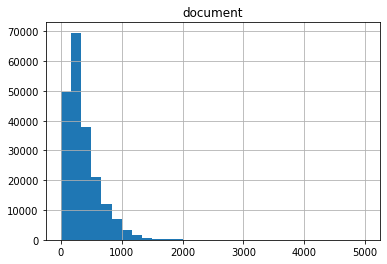

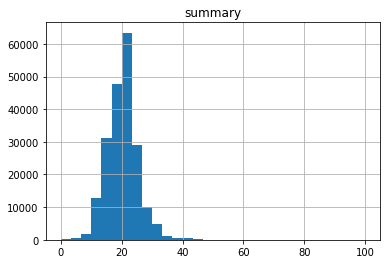

In [20]:
text_word_count = []
summary_word_count= []

for i in train['document']:
      text_word_count.append(len(i.split()))
        
for i in train['summary']:
      summary_word_count.append(len(i.split()))
        
text_length_df = pd.DataFrame({'document':text_word_count})
text_length_df.hist(bins = 30,range=(0,5000))

summary_length_df = pd.DataFrame({'summary':summary_word_count})
summary_length_df.hist(bins = 30,range=(0,100))

plt.show()

In [21]:
# maximum length for document
max_text_len = 1000

# maximum length for summaries
max_summary_len = 40

Let's add the __start-of-sentence__ and __end-of-sentence__ tokens ("sostok" and "eostok") to the summaries.

In [22]:
train['summary'] = train['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [23]:
test['summary'] = test['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [24]:
train.shape

(204045, 3)

In [25]:
test.shape

(11334, 3)

<br>

### Train-Test Split

In [26]:
x_tr, x_val, y_tr, y_val = train['document'], test['document'], train['summary'], test['summary']
text_tr, text_val, y_tr, y_val = train['reviews'], test['reviews'], train['summary'], test['summary']

In [27]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((204045,), (11334,), (204045,), (11334,))

### Create a Keras Tokenizer for Reviews

In [28]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer(num_words=5000) 
x_tokenizer.fit_on_texts(list(x_tr))

### Convert Text to Integer Sequences

In [29]:
#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr   =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val  =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary
x_voc   =  x_tokenizer.num_words + 1

### Create a Keras Tokenizer for Summaries / Titles

In [30]:
y_tokenizer = Tokenizer(num_words = 3000)   
y_tokenizer.fit_on_texts(list(y_tr))

In [31]:
summary_val = np.array(y_val)
text_val = np.array(text_val)

### Convert Summaries / Titles to Integer Sequences

In [32]:
# Convert word sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

Eliminate the summaries/titles sequences whose length is less than 4.

In [33]:
# eliminate the sequences from training data
index=[]
for i in range(len(y_tr_seq)):
    if(len(y_tr_seq[i])<=3):
        index.append(i)
        
y_tr_seq = np.delete(y_tr_seq,index, axis=0)
x_tr = np.delete(x_tr, index, axis=0)

# eliminate the sequences from test data
index = []
for i in range(len(y_val_seq)):
    if(len(y_val_seq[i])<=3):
        index.append(i)
        
y_val_seq = np.delete(y_val_seq,index, axis=0)
x_val = np.delete(x_val,index, axis=0)
text_val = np.delete(text_val,index,axis=0)
summary_val = np.delete(summary_val,index,axis=0)

In [34]:
#padding zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = y_tokenizer.num_words +1

<br>

## Build a Sequence-to-Sequence Model for Text Summarization

In [35]:
import keras
from keras.layers import Input, LSTM, Embedding, Dense, concatenate, TimeDistributed, Add, dot, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# No. of hidden nodes
latent_dim = 300
# Dimension of embeddings
embedding_dim=100

## Encoder-Decoder Structure for model training

#Encoder 
encoder_inputs=Input(shape=(max_text_len,))
encoder_embedding = Embedding(x_voc,embedding_dim, trainable=True, mask_zero=True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,go_backwards=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

#Decoder
decoder_inputs=Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True,mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_outputs, dec_state_h, dec_state_c = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Dense layer
dense_layer = TimeDistributed(Dense(latent_dim, activation="tanh"))
dense_outputs=dense_layer(decoder_outputs) 

#Output layer
output_layer = TimeDistributed(Dense(y_voc, activation="softmax"))
decoder_outputs=output_layer(dense_outputs)

model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 100)    500100      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    300100      ['input_2[0][0]']                
                                                                                              

In [36]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

### Define Early Stopping and Save Model

In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, min_delta=0.0001) 
mc = ModelCheckpoint('best_model_9.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [38]:
x_tr.shape

(203934, 1000)

### Initiate Model Training

In [39]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50, callbacks=[es,mc], batch_size=32, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
6373/6373 [==============================] - ETA: 0s - loss: 2.1808
Epoch 1: val_loss improved from inf to 1.93138, saving model to best_model_9.hdf5
6373/6373 [==============================] - 541s 83ms/step - loss: 2.1808 - val_loss: 1.9314
Epoch 2/50
6373/6373 [==============================] - ETA: 0s - loss: 1.8456
Epoch 2: val_loss improved from 1.93138 to 1.79173, saving model to best_model_9.hdf5
6373/6373 [==============================] - 530s 83ms/step - loss: 1.8456 - val_loss: 1.7917
Epoch 3/50
6373/6373 [==============================] - ETA: 0s - loss: 1.7328
Epoch 3: val_loss improved from 1.79173 to 1.72291, saving model to best_model_9.hdf5
6373/6373 [==============================] - 529s 83ms/step - loss: 1.7328 - val_loss: 1.7229
Epoch 4/50
6373/6373 [==============================] - ETA: 0s - loss: 1.6666
Epoch 4: val_loss improved from 1.72291 to 1.68445, saving model to best_model_9.hdf5
6373/6373 [==============================] - 529s 83ms/step - 

<br>

### Load the Saved Model

In [40]:
model=keras.models.load_model('best_model_9.hdf5')

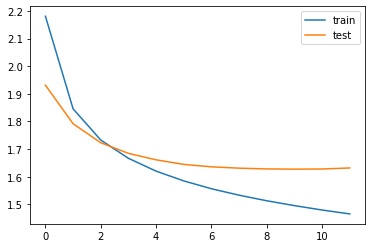

In [41]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Inference 

In [42]:
reverse_target_word_index=dict((v, k) for k, v in y_tokenizer.word_index.items())
reverse_source_word_index=dict((v, k) for k, v in x_tokenizer.word_index.items())

## Encoder-Decoder structure for model inference

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
dec_outputs, dec_h, dec_c = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

#dense layer
dense_outputs=dense_layer(dec_outputs)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = output_layer(dense_outputs) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [dec_h, dec_c])

In [43]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = y_tokenizer.word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out,e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence= decoded_sentence+sampled_token+' '

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.strip()

### Convert Validation Integer Sequences back to Text

In [44]:
def seq2source(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString.strip()

In [45]:
source=[]
for i in range(len(x_val)):
    source.append(seq2source(x_val[i]))  

In [46]:
summary_val=[' '.join(i.split()[1:-1]) for i in summary_val]

In [47]:
index=[]
for i in range(len(source)):
    if(len(source[i].split()) >= 10):
        index.append(i)

### Generate Some Summaries

In [48]:
from rouge import Rouge
rouge = Rouge()

In [49]:
for i in random.sample(range(0,len(text_val)+1),20):
    print("Review:",text_val[index[i]],"\n")
    actual = summary_val[index[i]]
    print("Actual summary:",actual)
    model_out=decode_sequence(x_val[index[i]].reshape(1,max_text_len))
    print("Predicted summary:",model_out)
    print("\n")
    print("Eval Metrics:")
    print(rouge.get_scores(model_out, actual, avg=True))
    print("\n")

Review: Visiting striker Harry Kane fired home from the spot in the second half after Raheem Sterling was controversially penalised for handball.
Yaya Toure struck a 20-yard free-kick against the bar before teenage substitute Kelechi Iheanacho levelled.
But Spurs earned a fifth league win in a row as Eriksen slotted in.
The Dane was played through on goal by substitute Erik Lamela to coolly finish, after Iheanacho had shot high into the net to restore parity.
Arsenal's win over leaders Leicester earlier in the day temporarily moved the Gunners into second place but Spurs have gone back ahead of their north London rivals on goal difference.
Analysis: Spirit, fitness and belief - why Spurs can win title
Relive Tottenham's win at Manchester City
Listen: Ramon Vega - "I have no doubts Spurs will grab the league"
Media playback is not supported on this device
Manuel Pellegrini's side won 21 points from their opening nine league games but have claimed just 26 points from their subsequent 17 

# Testing Model

In [50]:
text1='''
My Puppy was on Royal Canin but we switched her to Wellness Pupy b/c I eventually wanted her on Wellness Core but she doesn't seem to like it.  I have to mix the can with it in order for her to eat it.  She was with a dog sitter for a week while we were out of the country and she came back with her food container full.  She seemed more solid, like she'd gained a lot more weight in just a week.  Apparently she ate their dog food and wouldn't touch her more expensive food.  Now that she's home, she's gone back to barely eating it.  I'll try another brand after we finish this bag.  I'm sure the nutrition in it is great  but if I can't get my dog to eat it, what good is it? 
'''

In [51]:
actual1='''my puppy likes purina better
'''

In [52]:
df = pd.DataFrame({
    'document': [text1],
    'summary': [actual1]})
df.head()

,document,summary
0,\nMy Puppy was on Royal Canin but we switched her to Wellness Pupy b/c I eventually wanted her on Wellness Core but she doesn't seem to like it. I have to mix the can with it in order for her to ...,my puppy likes purina better\n


In [53]:
# preprocess review text
cleaned_text2 = []
reviews2=np.array(df['document'])

for i in range(len(reviews2)):
    cleaned_text2.append(text_cleaner(reviews2[i]))
    
    
# preprocess titles
cleaned_summary2 = []
summary2=np.array(df['summary'])

for i in range(len(summary2)):
    cleaned_summary2.append(text_cleaner(summary2[i]))
    
# create a dataframe
test1=pd.DataFrame({'document':cleaned_text2,'summary':cleaned_summary2,'reviews':reviews2})

test1['summary'] = test1['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

x_val1, y_val1 = test1['document'], test1['summary']
text_val1, y_val1 = test1['reviews'], test1['summary']

#convert text sequences into integer sequences
x_val_seq1  =   x_tokenizer.texts_to_sequences(x_val1)

#padding zero upto maximum length
x_val1  =   pad_sequences(x_val_seq1, maxlen=max_text_len, padding='post')

summary_val1 = np.array(y_val1)
text_val1 = np.array(text_val1)

# Convert word sequences to integer sequences
y_val_seq1 = y_tokenizer.texts_to_sequences(y_val1)

# eliminate the sequences from test data
index1 = []
for i in range(len(y_val_seq1)):
    if(len(y_val_seq[i])<=3):
        index1.append(i)
        
y_val_seq1 = np.delete(y_val_seq1,index1, axis=0)
x_val1 = np.delete(x_val1,index1, axis=0)
text_val1 = np.delete(text_val1,index1,axis=0)
summary_val1 = np.delete(summary_val1,index1,axis=0)

#padding zero upto maximum length
y_val1 = pad_sequences(y_val_seq1, maxlen=max_summary_len, padding='post')

source1=[]
for i in range(len(x_val1)):
    source1.append(seq2source(x_val1[i]))  
    
summary_val1=[' '.join(i.split()[1:-1]) for i in summary_val1]

index1=[]
for i in range(len(source1)):
    if(len(source1[i].split()) >= 10):
        index1.append(i)

In [54]:
print("Review:",text_val1[index1[0]],"\n")
actual = summary_val1[index1[0]]
print("Actual summary:",actual1)
model_out1=decode_sequence(x_val1[index1[0]].reshape(1,max_text_len))
print("Predicted summary:",model_out1)
print("\n")
print("Eval Metrics:")
print(rouge.get_scores(model_out1, actual1, avg=True))
print("\n")

Review: 
My Puppy was on Royal Canin but we switched her to Wellness Pupy b/c I eventually wanted her on Wellness Core but she doesn't seem to like it.  I have to mix the can with it in order for her to eat it.  She was with a dog sitter for a week while we were out of the country and she came back with her food container full.  She seemed more solid, like she'd gained a lot more weight in just a week.  Apparently she ate their dog food and wouldn't touch her more expensive food.  Now that she's home, she's gone back to barely eating it.  I'll try another brand after we finish this bag.  I'm sure the nutrition in it is great  but if I can't get my dog to eat it, what good is it? 
 

Actual summary: my puppy likes purina better

Predicted summary: is the first woman in the uk to be born in the uk


Eval Metrics:
{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}


